In [1]:
from train import Net
from torch.utils.data import Dataset
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from cautious_extrapolation.data_paths import DATA_PATHS
from cautious_extrapolation.utils import get_imagenet_features


/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class P_MNIST(Dataset):
    def __init__(self, perturbed_imgs, labels, transform=None):
        self.transform = transform
        self.imgs = perturbed_imgs
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.imgs[idx]
        if self.transform:
            img = self.transform(img)
        label = self.labels[idx]
        return img, label

In [4]:
model = Net().to("cuda")
model.load_state_dict(torch.load(os.path.join("data", "model1.pt")))
model.eval()
model.cuda()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [5]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

test_dataset = datasets.MNIST(DATA_PATHS["desktop"]["MNIST"], train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1024)

In [6]:
file = open(os.path.join("data", "perturbed_ds_10.pkl"),'rb')
data = pickle.load(file)
file.close()
p_data_loader = torch.utils.data.DataLoader(P_MNIST(data["image"].astype(float), data["label"]), batch_size=1024)

In [7]:
data["image"].shape

(10000, 1, 28, 28)

In [8]:
test_outputs = []
for batch_idx, (data, target) in enumerate(test_loader):
    data, target = data.cuda().float(), target.cuda().long()
    output = model(data)
    output = torch.e**output
    test_outputs.append(output.detach().cpu().numpy())
test_outputs = np.concatenate(test_outputs, axis=0)

test_features = get_imagenet_features(test_loader, UTKFace=True)

/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
p_outputs = []
for batch_idx, (data, target) in enumerate(p_data_loader):
    data, target = data.cuda().float(), target.cuda().long()
    output = model(data)
    output = torch.e**output
    p_outputs.append(output.detach().cpu().numpy())
p_outputs = np.concatenate(p_outputs, axis=0)
p_features = get_imagenet_features(p_data_loader, UTKFace=True)

In [10]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler 
from sklearn.pipeline import make_pipeline

idxs = np.random.permutation(10000)
val_features = test_features[idxs]
val_features_train = val_features[1000:]

ood_features = p_features
idxs = np.random.permutation(10000)
ood_features = ood_features[idxs]
ood_features_train = ood_features[1000:]

X = np.concatenate((val_features_train, ood_features_train), axis=0)
y = np.concatenate((np.ones(9000), np.zeros(9000)), axis=0)

scores = []
for _ in range(30):
    clf = make_pipeline(StandardScaler(), SGDClassifier(loss="log", max_iter=20, alpha=10))
    clf.fit(X, y)
    score = clf.predict_log_proba(ood_features[:1000])[:, 0].mean()
    scores.append(score)
ood_score = (np.mean(scores))

In [11]:
ood_score = np.e**ood_score

In [12]:
class_probs = [0.1 for _ in range(10)]
test_dist_from_f_start = (np.sum(test_outputs*np.clip(np.log(test_outputs/np.expand_dims(class_probs, axis=0)), -9999, 9999), axis=-1).mean())
p_dist_from_f_start = (np.sum(p_outputs*np.clip(np.log(p_outputs/np.expand_dims(class_probs, axis=0)), -9999900, 9999900), axis=-1).mean())

/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  


(0.45, 0.9)

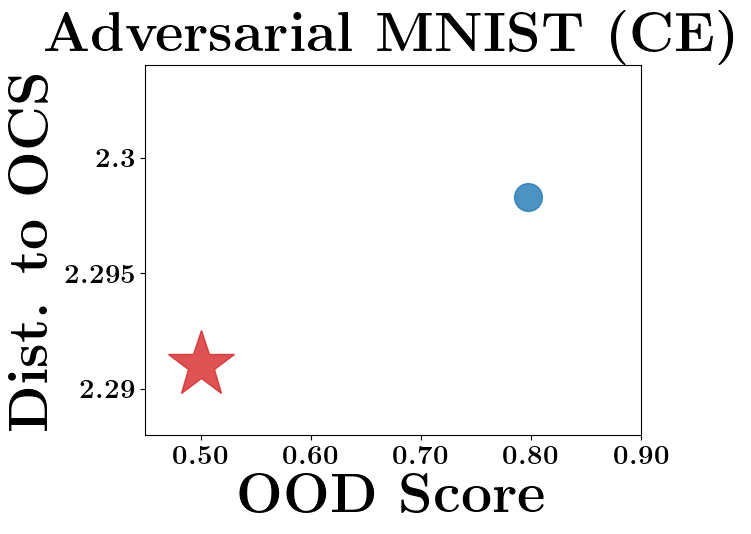

: 

In [13]:
import matplotlib.pyplot as plt

import matplotlib as mpl
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
mpl.rcParams['text.latex.preamble'] = [r'\boldmath']

colors=["C3", "C0", "C1", "C2", "C4", "C5", "C6", "C7", "C8", "C9"]

plt.errorbar([0.5], [test_dist_from_f_start], yerr=[0], fmt='*', markersize=50, zorder=100, alpha=0.8, color=colors[0])
plt.errorbar([ood_score], [p_dist_from_f_start], yerr=[0], fmt="o", markersize=20, alpha=0.8, color=colors[1])


plt.xlabel(r"\textbf{OOD Score}", fontsize=40)
plt.ylabel(r"$\textbf{Dist. to OCS}$", fontsize=40)
plt.title(r"\textbf{Adversarial MNIST (CE)}", fontsize=40)
plt.yticks([2.29+_*0.005 for _ in range(7)], [r"\textbf{"+str(2.29+_*0.005)+"}" for _ in range(7)], fontsize=20)
plt.xticks([0.5+0.1*_ for _ in range(10)], [r"\textbf{%.2f}"%(0.5+0.1*_) for _ in range(10)], fontsize=20)
plt.ylim([2.288, 2.304])
plt.xlim([0.45, 0.9])